# New take on selecting MDL tests

# Purpose
Find suitable MDL reference tests where:
* More than 2 speeds
* No bilge keels
* High A0 mid section coefficient
* Possible low wave damping

# Methodology
Search in the database

# Setup

In [2]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import rolldecayestimators.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables
import shipflowmotionshelpers.shipflowmotionshelpers as helpers
import src.visualization.visualize as visualize


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df_rolldecay = database.load(rolldecay_table_name='rolldecay_quadratic_b', limit_score=0.99, 
                             exclude_table_name='rolldecay_exclude')

In [18]:
mask = df_rolldecay.BKL == 0
df = df_rolldecay.loc[mask].copy()

df_speed_variations = df.groupby(by = 'loading_condition_id').filter(lambda x: len(x['ship_speed'].unique()) > 1)
loading_conditions = df_speed_variations.groupby(by = 'loading_condition_id').first()
#loading_conditions

In [19]:
loading_condition = loading_conditions.loc[134]

print(loading_condition.project_path)

S:\2015\20157491-SDARI---twin-skeg-type-modular-carrier


In [20]:
loading_condition.TA

7.5

In [53]:
loading_condition.TF

7.5

In [22]:
loading_condition.lpp

193.8

In [80]:
draught = (loading_condition.TA + loading_condition.TF)/2

In [81]:
file_path = r'S:\2020\40209514-DEMOPS\03_Project\020_PROJECT_MANAGEMENT\arbetsmapp\ISOPE\points3d.txt'
points = pd.read_csv(file_path, sep=';', header=None)
points.columns = ['x','y','z']
points.describe()

,x,y,z
count,20717.000000,2.071700e+04,20717.000000
mean,80.594084,1.318084e+01,3.348210
std,68.325128,7.027157e+00,3.624176
min,-4.795000,-6.895055e-08,-0.003182
25%,23.041486,7.395656e+00,0.414801
50%,43.918851,1.268134e+01,2.206803
75%,159.624595,2.050386e+01,5.384788
max,201.505000,2.150280e+01,20.500002


In [140]:
x = points['x'].unique()

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


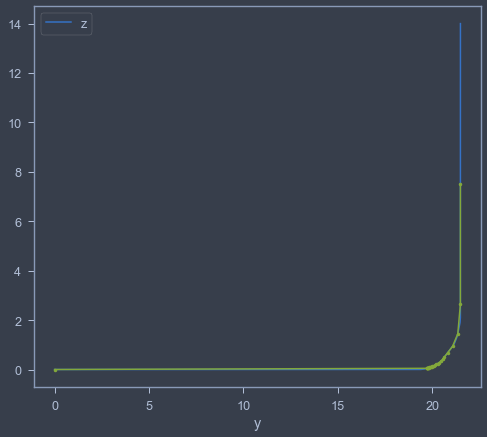

In [141]:
x_groups = points.groupby(by='x')
N = 30
z_ = np.linspace(0,1,N)**-1.5
z_ = z_/z_[1]
z = draught*z_[1:]
z = np.concatenate((z,[0]))
z = np.flipud(z)


section = x_groups.get_group(x[int(len(x)/2)])
section.sort_values(by='z', inplace=True)
y = np.interp(z, section['z'], section['y'])
    

fig,ax=plt.subplots()
section.plot(x='y', y='z', ax=ax)
ax.plot(y,z,'.-')

In [142]:
x_groups = points.groupby(by='x')
N = 30
z_ = np.linspace(0,1,N)**-1.5
z_ = z_/z_[1]
z = draught*z_[1:]
z = np.concatenate((z,[0]))
z = np.flipud(z)

coordinates = np.zeros((len(x_groups),len(z)))

for i,(_, section) in enumerate(x_groups):
    section.sort_values(by='z', inplace=True)
    y = np.interp(z, section['z'], section['y'])
    
    coordinates[i] = y

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


In [143]:
coordinates[int(len(x)/2),:]

array([ 0.        , 19.70403753, 19.71393238, 19.72475181, 19.73662144,
       19.74968976, 19.76413336, 19.78016373, 19.79803614, 19.81806117,
       19.84062012, 19.86618575, 19.89535063, 19.92886636, 19.96769915,
       20.0131097 , 20.06677087, 20.12285403, 20.17087832, 20.22662691,
       20.28770239, 20.36619887, 20.45992018, 20.55021633, 20.65556479,
       20.81607487, 21.08275456, 21.3594881 , 21.49791588, 21.49880709])